# Importing Libraries

In [414]:
import math
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

# Simulating Data

In [415]:
X = pd.DataFrame(np.random.normal(size=100))
epsilon = pd.DataFrame(np.random.normal(size=100))
Y = 5 + 7 * X + 2 * X ** 2 + 3 * X ** 3 + epsilon
Y.head()

,0
0,16.004954
1,2.751889
2,-1.627573
3,-0.352291
4,4.682094


In [416]:
df = pd.DataFrame()
for i in range(10):
    df["X ** " + str(i+1)] = X ** (i+1)

X = df
X.head()

,X ** 1,X ** 2,X ** 3,X ** 4,X ** 5,X ** 6,X ** 7,X ** 8,X ** 9,X ** 10
0,0.928377,0.861883,0.800152,0.742842,0.689638,6.402433e-01,5.943869e-01,5.518149e-01,5.122920e-01,4.755999e-01
1,-0.532517,0.283574,-0.151008,0.080414,-0.042822,2.280350e-02,-1.214325e-02,6.466490e-03,-3.443517e-03,1.833732e-03
2,-0.975275,0.951161,-0.927643,0.904706,-0.882337,8.605210e-01,-8.392442e-01,8.184936e-01,-7.982560e-01,7.785188e-01
3,-0.768247,0.590203,-0.453421,0.348339,-0.267610,2.055908e-01,-1.579444e-01,1.213402e-01,-9.321922e-02,7.161534e-02
4,0.065803,0.004330,0.000285,0.000019,0.000001,8.118743e-08,5.342407e-09,3.515484e-10,2.313307e-11,1.522234e-12


# Best Subset Selection

In [417]:
# Return best regression models with k predictors
best_models = []

m = X.shape[1]
for k in range(1, m+1):
    min_RSS = np.inf
    best_model = []
    for combo in combinations(X.columns, k):
        lm = LinearRegression()
        lm.fit(X[list(combo)], Y)
        Y_predict = lm.predict(X[list(combo)])
        RSS = np.sum(np.square(Y - Y_predict))[0]
        if RSS < min_RSS:
            min_RSS = RSS
            best_model = lm

    best_models.append([best_model, min_RSS])

best_models

[[LinearRegression(), 1554.6009621415049],
 [LinearRegression(), 554.2908441589054],
 [LinearRegression(), 104.61619831155993],
 [LinearRegression(), 102.56592440114869],
 [LinearRegression(), 100.28805249657296],
 [LinearRegression(), 98.14642482740497],
 [LinearRegression(), 97.62015418886588],
 [LinearRegression(), 97.07962283415725],
 [LinearRegression(), 96.46846521580687],
 [LinearRegression(), 96.4309519984332]]

In [418]:
# Estimating variance of error epsilon
n = Y.size

var_estimate = math.sqrt(1/(n-1) * best_models[-1][1])
var_estimate

0.9869397246976099

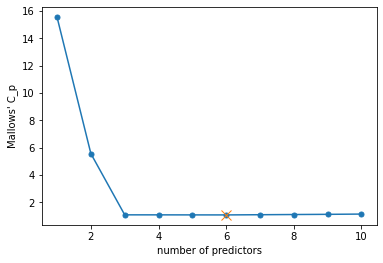

In [419]:
# Mallows' C_p statistic - same as Akaike Information Criterion (AIC) with Gaussian errors
C_p = []
for d in range(m):
    C_p.append(1/n * (best_models[d][1] + 2 * d * var_estimate))

plt.plot(range(1, m+1), C_p, marker="o", ms=5)
plt.plot(np.argmin(C_p) + 1, min(C_p), marker="x", ms=10)

plt.xlabel("number of predictors")
plt.ylabel("Mallows' C_p")

plt.show()

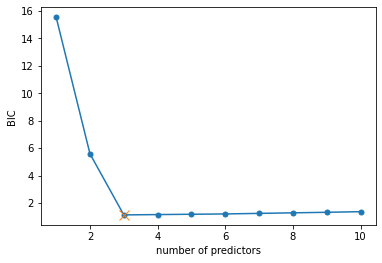

In [420]:
# Bayesian Information Criterion (BIC)
BIC = []
for d in range(m):
    BIC.append(1/n * (best_models[d][1] + np.log(n) * d * var_estimate))

plt.plot(range(1, m+1), BIC, marker="o", ms=5)
plt.plot(np.argmin(BIC) + 1, min(BIC), marker="x", ms=10)

plt.xlabel("number of predictors")
plt.ylabel("BIC")

plt.show()

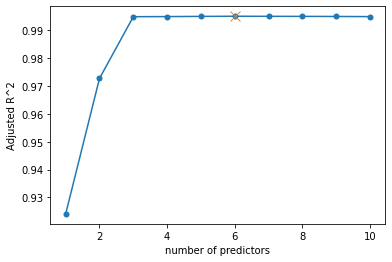

In [421]:
# Adjusted R^2
adj_R2 = []
TSS = np.sum(np.square(Y - Y.mean()))[0]
for d in range(m):
    adj_R2.append(1 - (best_models[d][1] / (n-d-1)) / (TSS / (n-1)))

plt.plot(range(1, m+1), adj_R2, marker="o", ms=5)
plt.plot(np.argmax(adj_R2) + 1, max(adj_R2), marker="x", ms=10)

plt.xlabel("number of predictors")
plt.ylabel("Adjusted R^2")

plt.show()

# Forward Stepwise Selection

In [422]:
# Find best models with k
best_models = []

m = X.shape[1]
for k in range(m):
    min_RSS = np.inf
    best_model = []
    best_features = []

    if k == 0:
        prev_features = []
    else:
        prev_features = best_models[k-1][2]

    for feature in X.columns:
        if feature not in prev_features:
            features = prev_features + [feature]
            lm = LinearRegression()
            lm.fit(X[features], Y)
            Y_predict = lm.predict(X[features])
            RSS = np.sum(np.square(Y - Y_predict))[0]
            if RSS < min_RSS:
                min_RSS = RSS
                best_model = lm
                best_features = features

    best_models.append([best_model, min_RSS, best_features])

best_models

[[LinearRegression(), 1554.6009621415049, ['X ** 3']],
 [LinearRegression(), 554.2908441589054, ['X ** 3', 'X ** 1']],
 [LinearRegression(), 104.61619831155993, ['X ** 3', 'X ** 1', 'X ** 2']],
 [LinearRegression(),
  102.56592440114865,
  ['X ** 3', 'X ** 1', 'X ** 2', 'X ** 10']],
 [LinearRegression(),
  101.46601582991177,
  ['X ** 3', 'X ** 1', 'X ** 2', 'X ** 10', 'X ** 8']],
 [LinearRegression(),
  98.14642482740494,
  ['X ** 3', 'X ** 1', 'X ** 2', 'X ** 10', 'X ** 8', 'X ** 9']],
 [LinearRegression(),
  97.62015418886583,
  ['X ** 3', 'X ** 1', 'X ** 2', 'X ** 10', 'X ** 8', 'X ** 9', 'X ** 6']],
 [LinearRegression(),
  97.07962283415723,
  ['X ** 3',
   'X ** 1',
   'X ** 2',
   'X ** 10',
   'X ** 8',
   'X ** 9',
   'X ** 6',
   'X ** 5']],
 [LinearRegression(),
  96.57614165948361,
  ['X ** 3',
   'X ** 1',
   'X ** 2',
   'X ** 10',
   'X ** 8',
   'X ** 9',
   'X ** 6',
   'X ** 5',
   'X ** 4']],
 [LinearRegression(),
  96.43095199843322,
  ['X ** 3',
   'X ** 1',
   'X 

In [423]:
# Estimating variance of error epsilon
n = Y.size

var_estimate = math.sqrt(1/(n-1) * best_models[-1][1])
var_estimate

0.9869397246976099

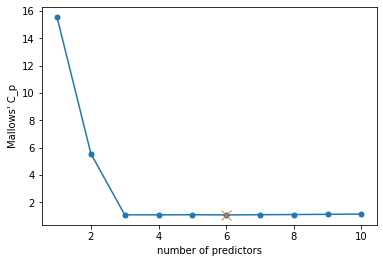

In [424]:
# Mallows' C_p statistic - same as Akaike Information Criterion (AIC) with Gaussian errors
C_p = []
for d in range(m):
    C_p.append(1/n * (best_models[d][1] + 2 * d * var_estimate))

plt.plot(range(1, m+1), C_p, marker="o", ms=5)
plt.plot(np.argmin(C_p) + 1, min(C_p), marker="x", ms=10)

plt.xlabel("number of predictors")
plt.ylabel("Mallows' C_p")

plt.show()

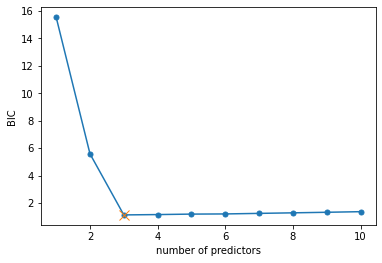

In [425]:
# Bayesian Information Criterion (BIC)
BIC = []
for d in range(m):
    BIC.append(1/n * (best_models[d][1] + np.log(n) * d * var_estimate))

plt.plot(range(1, m+1), BIC, marker="o", ms=5)
plt.plot(np.argmin(BIC) + 1, min(BIC), marker="x", ms=10)

plt.xlabel("number of predictors")
plt.ylabel("BIC")

plt.show()

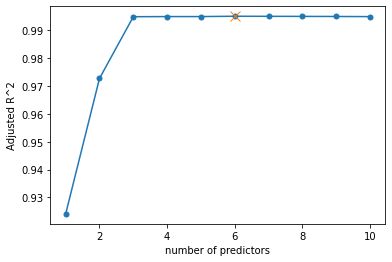

In [426]:
# Adjusted R^2
adj_R2 = []
TSS = np.sum(np.square(Y - Y.mean()))[0]
for d in range(m):
    adj_R2.append(1 - (best_models[d][1] / (n-d-1)) / (TSS / (n-1)))

plt.plot(range(1, m+1), adj_R2, marker="o", ms=5)
plt.plot(np.argmax(adj_R2) + 1, max(adj_R2), marker="x", ms=10)

plt.xlabel("number of predictors")
plt.ylabel("Adjusted R^2")

plt.show()

# Backward Stepwise Selection

In [427]:
# Find best models with k
best_models = []

m = X.shape[1]
for k in range(m):
    min_RSS = np.inf
    best_model = []
    best_features = []

    if k == 0:
        lm = LinearRegression()
        lm.fit(X, Y)
        Y_predict = lm.predict(X)
        RSS = np.sum(np.square(Y - Y_predict))[0]
        best_models.append([lm, RSS, list(X.columns)])
        continue

    prev_features = best_models[k-1][2]
    for feature in prev_features:
        features = list(set(prev_features) - {feature})
        lm = LinearRegression()
        lm.fit(X[features], Y)
        Y_predict = lm.predict(X[features])
        RSS = np.sum(np.square(Y - Y_predict))[0]
        if RSS < min_RSS:
            min_RSS = RSS
            best_model = lm
            best_features = features

    best_models.append([best_model, min_RSS, best_features])

best_models.reverse()

In [428]:
# Estimating variance of error epsilon
n = Y.size

var_estimate = math.sqrt(1/(n-1) * best_models[-1][1])
var_estimate

0.9869397246976099

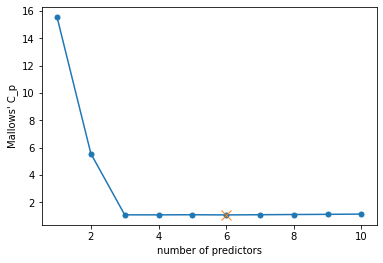

In [429]:
# Mallows' C_p statistic - same as Akaike Information Criterion (AIC) with Gaussian errors
C_p = []
for d in range(m):
    C_p.append(1/n * (best_models[d][1] + 2 * d * var_estimate))

plt.plot(range(1, m+1), C_p, marker="o", ms=5)
plt.plot(np.argmin(C_p) + 1, min(C_p), marker="x", ms=10)

plt.xlabel("number of predictors")
plt.ylabel("Mallows' C_p")

plt.show()

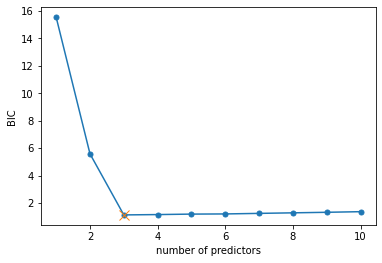

In [430]:
# Bayesian Information Criterion (BIC)
BIC = []
for d in range(m):
    BIC.append(1/n * (best_models[d][1] + np.log(n) * d * var_estimate))

plt.plot(range(1, m+1), BIC, marker="o", ms=5)
plt.plot(np.argmin(BIC) + 1, min(BIC), marker="x", ms=10)

plt.xlabel("number of predictors")
plt.ylabel("BIC")

plt.show()

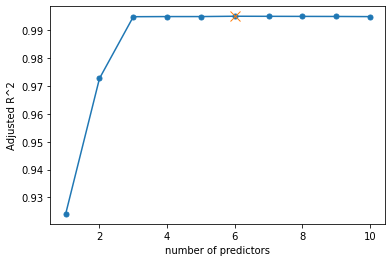

In [431]:
# Adjusted R^2
adj_R2 = []
TSS = np.sum(np.square(Y - Y.mean()))[0]
for d in range(m):
    adj_R2.append(1 - (best_models[d][1] / (n-d-1)) / (TSS / (n-1)))

plt.plot(range(1, m+1), adj_R2, marker="o", ms=5)
plt.plot(np.argmax(adj_R2) + 1, max(adj_R2), marker="x", ms=10)

plt.xlabel("number of predictors")
plt.ylabel("Adjusted R^2")

plt.show()

# Lasso Regression Model

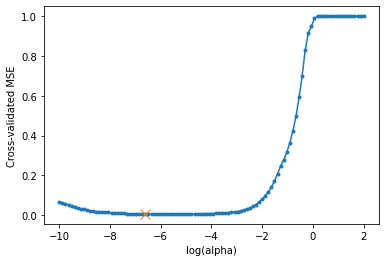

In [432]:
# Using cross-validation to select optimal alpha value for the lasso
alpha_vals = math.e ** np.linspace(-10, 2, 100)

scores = []

X_reg = (X - X.mean()) / X.std()
Y_reg = (Y - Y.mean()) / Y.std()

for alpha in alpha_vals:
    lasso_reg = Lasso(alpha=alpha, max_iter=100000)
    lasso_reg.fit(X_reg, Y_reg)
    Y_predict = lasso_reg.predict(X_reg).reshape(-1, 1)
    score = np.mean(cross_val_score(lasso_reg, X_reg, Y_reg, scoring=make_scorer(mean_squared_error), cv=5))
    scores.append(score)

best_alpha = alpha_vals[np.argmin(scores)]

plt.plot(np.log(alpha_vals), scores, marker="o", ms=3)
plt.plot(np.log(best_alpha), min(scores), marker="x", ms=10)
plt.xlabel("log(alpha)")
plt.ylabel("Cross-validated MSE")

plt.show()

In [433]:
# Fit optimal Lasso regression model found above
lasso_reg = Lasso(alpha=best_alpha)
lasso_reg.fit(X_reg, Y_reg)
lasso_reg.coef_

array([0.47693049, 0.151009  , 0.50834193, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01532999])

In [434]:
# Checking work
lasso_cv = LassoCV()
lasso_cv.fit(X_reg, np.ravel(Y_reg))
lasso_cv.coef_

array([0.47706031, 0.15106912, 0.50827265, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01539728])